# CLEANING & FEATURE ENGINEERING

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Tuple, List
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Sequential
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf
import random

In [3]:
train = pd.read_csv("/Users/elena/Downloads/train_1.csv")

In [4]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
def split_page(page: str) -> Tuple[str, str, str, str]:
    """
    Splits a page string into its components: Title, Language, Access type, and Access origin.
    
    Args:
    page (str): The page string to be split.
    
    Returns:
    Tuple[str, str, str, str]: A tuple containing Title, Language, Access type, and Access origin.
    """
    components = re.split(r'_|\.', page)
    return ' '.join(components[:-5]), components[-5], components[-2], components[-1]

# Drop null values
train.dropna(inplace=True)

# Reshape the DataFrame to have each row as an individual observation
train_flattened = pd.melt(
    train[list(train.columns[-100:]) + ['Page']], 
    id_vars='Page',
    var_name='date', 
    value_name='visits'
)

# Convert date column to datetime format
train_flattened['date'] = pd.to_datetime(train_flattened['date'])

# Add a column to indicate if the date is a weekend (1) or a weekday (0)
train_flattened['weekend'] = (train_flattened['date'].dt.dayofweek // 5).astype(int)

# Changing visits from float to int
train_flattened['visits'] = train_flattened['visits'].astype(int)

# Reset index and keep the old index as a new column
train_flattened.reset_index(drop=False, inplace=True)

# Add a column indicating the day of the week for each date
train_flattened['weekday'] = train_flattened['date'].dt.weekday

# Extract year, month, and day from the date
train_flattened['year'] = train_flattened['date'].dt.year
train_flattened['month'] = train_flattened['date'].dt.month
train_flattened['day'] = train_flattened['date'].dt.day

# Split the 'Page' column into multiple components
page_components = train['Page'].apply(split_page).tolist()
df_components = pd.DataFrame(page_components, columns=['Title', 'Language', 'Access_type', 'Access_origin'])

# Replace language codes with full names
language_mapping = {
    'en': 'English',
    'ja': 'Japanese',
    'de': 'German',
    'fr': 'French',
    'zh': 'Chinese',
    'ru': 'Russian',
    'es': 'Spanish'
}

df_components['Language'] = df_components['Language'].replace(language_mapping)

# Concatenate the new DataFrame with the original train DataFrame
train_flattened = pd.concat([train_flattened, df_components], axis=1)

# Drop the original 'Page' column
train_flattened.drop(columns=['Page'], inplace=True)
df = train_flattened

In [6]:
df.head()

,index,date,visits,weekend,weekday,year,month,day,Title,Language,Access_type,Access_origin
0,0,2016-09-23,10,0,4,2016,9,23,2NE1,Chinese,all-access,spider
1,1,2016-09-23,26,0,4,2016,9,23,2PM,Chinese,all-access,spider
2,2,2016-09-23,3,0,4,2016,9,23,3C,Chinese,all-access,spider
3,3,2016-09-23,14,0,4,2016,9,23,4minute,Chinese,all-access,spider
4,4,2016-09-23,15,0,4,2016,9,23,5566,Chinese,all-access,spider


## EXPLORATION

<Axes: xlabel='Language'>

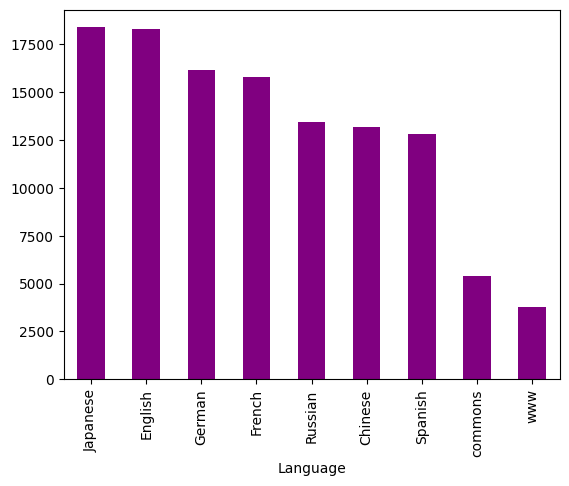

In [8]:
df.Language.value_counts().plot(kind = 'bar', color='purple')

'commons' & 'www' are pages with unspecified languages. Most common languages are English, Japanese, and German. 

<Axes: xlabel='Access_type'>

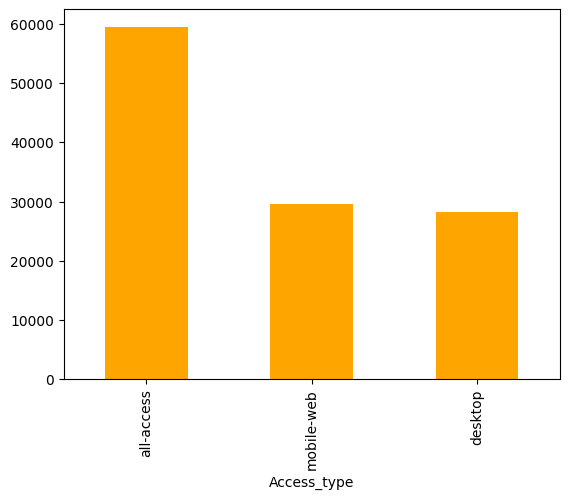

In [10]:
df.Access_type.value_counts().plot(kind = 'bar', color='orange')

<Axes: xlabel='Access_origin'>

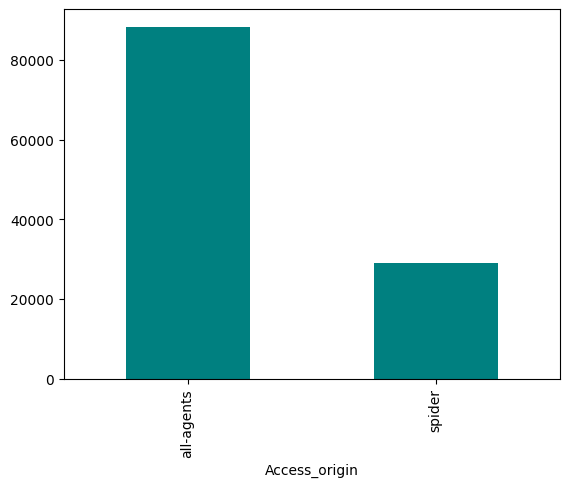

In [11]:
df.Access_origin.value_counts().plot(kind = 'bar', color = 'teal')

A 'spider' is a type of bot (typically operated by search engines) that analyses the content of websites all across the internet so that those websites can appear in search engine results. 

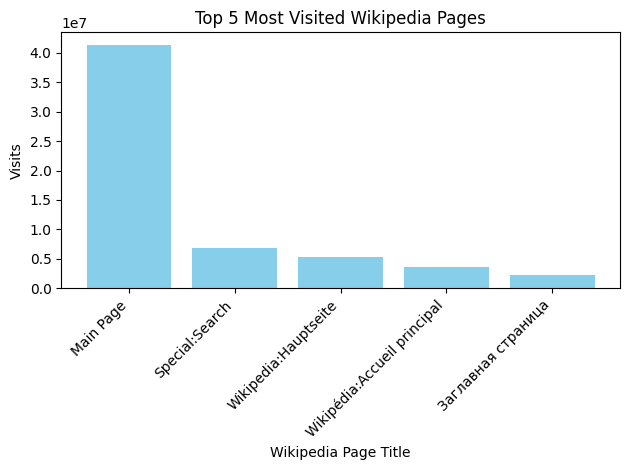

In [13]:
# Top 5 Most Visited Wiki Pages

title_visits = df.groupby('Title')['visits'].sum().reset_index()
top_titles = title_visits.sort_values(by='visits', ascending=False).head(5)

plt.bar(top_titles['Title'], top_titles['visits'], color='skyblue')

plt.xlabel('Wikipedia Page Title')
plt.ylabel('Visits')
plt.title('Top 5 Most Visited Wikipedia Pages')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

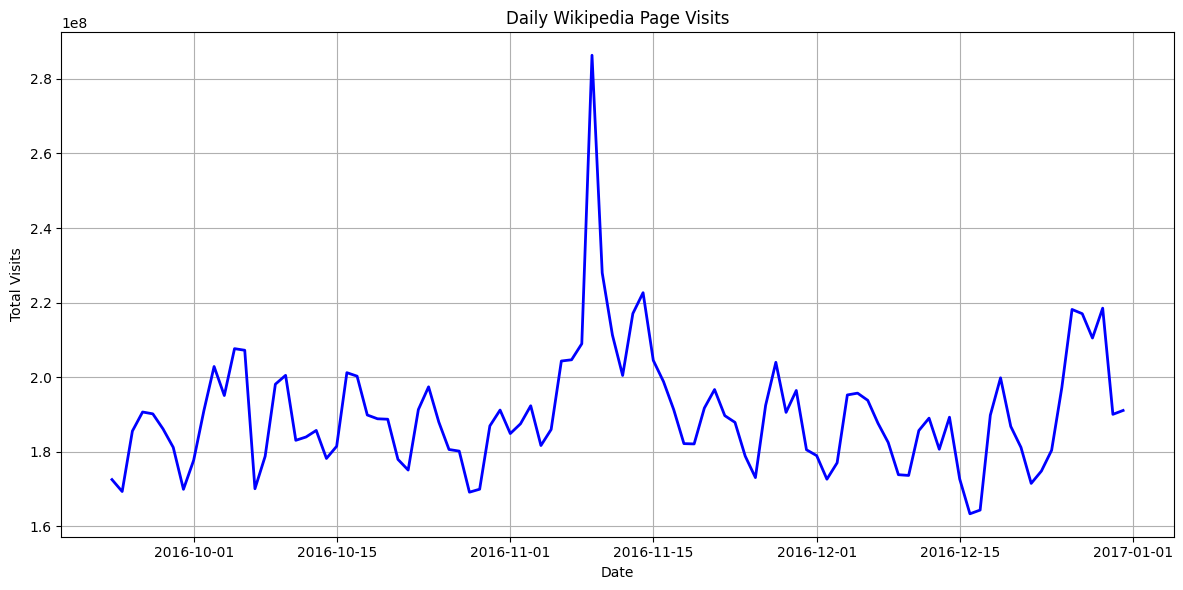

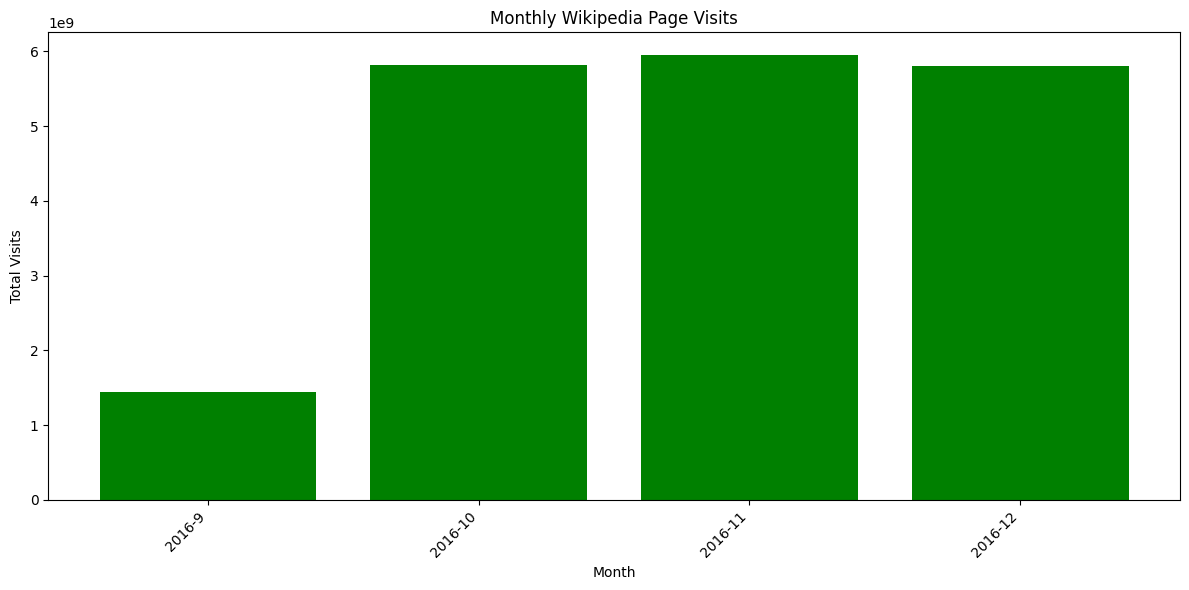

In [14]:
# Pattern of visits over time

# By day
daily_visits = df.groupby('date')['visits'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_visits['date'], daily_visits['visits'], color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Visits')
plt.title('Daily Wikipedia Page Visits')
plt.grid(True)
plt.tight_layout()
plt.show()

# By month
monthly_visits = df.groupby(['year', 'month'])['visits'].sum().reset_index()
monthly_visits['year_month'] = monthly_visits['year'].astype(str) + '-' + monthly_visits['month'].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(monthly_visits['year_month'], monthly_visits['visits'], color='green', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Total Visits')
plt.title('Monthly Wikipedia Page Visits')
plt.tight_layout()
plt.show()

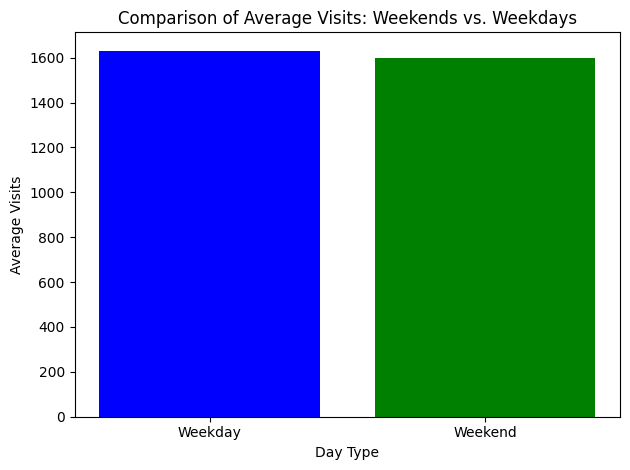

In [15]:
# Weekend Traffic VS Weekday Traffic

weekend_vs_weekday = df.groupby('weekend')['visits'].mean().reset_index()
weekend_vs_weekday.columns = ['Weekend', 'Average Visits']

weekend_vs_weekday['Weekend'] = weekend_vs_weekday['Weekend'].replace({0: 'Weekday', 1: 'Weekend'})

plt.bar(weekend_vs_weekday['Weekend'], weekend_vs_weekday['Average Visits'], color=['blue', 'green'])
plt.xlabel('Day Type')
plt.ylabel('Average Visits')
plt.title('Comparison of Average Visits: Weekends vs. Weekdays')
plt.tight_layout()
plt.show()


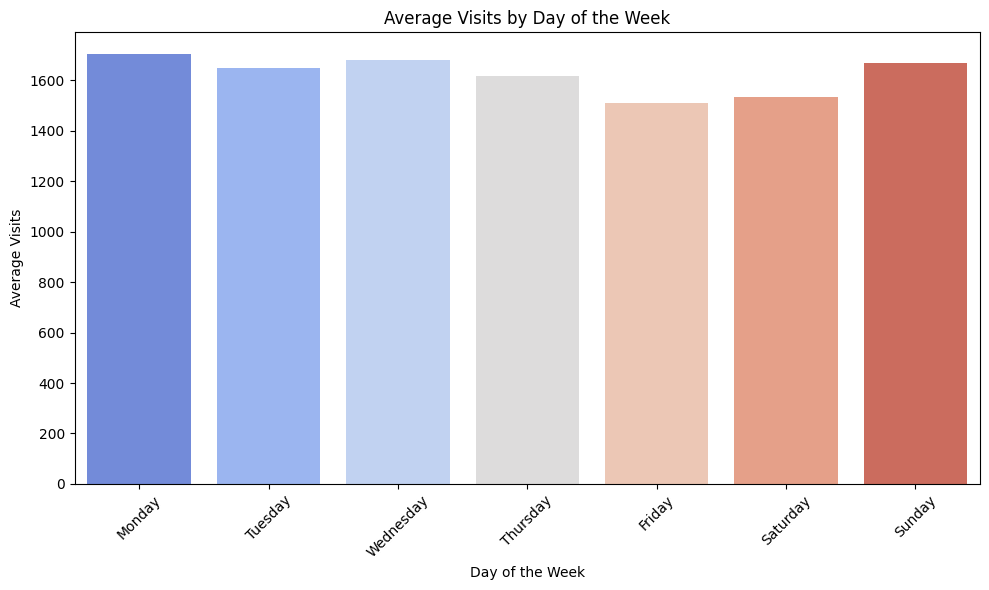

In [16]:
# Traffic by day of week

weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                   4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['weekday_name'] = df['weekday'].map(weekday_mapping)
weekday_visits = df.groupby('weekday_name')['visits'].mean().reset_index()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_visits['weekday_name'] = pd.Categorical(weekday_visits['weekday_name'], categories=days_order, ordered=True)
weekday_visits = weekday_visits.sort_values('weekday_name')

plt.figure(figsize=(10, 6))
sns.barplot(x='weekday_name', y='visits', data=weekday_visits, palette='coolwarm', order=days_order, hue='weekday_name')
plt.title('Average Visits by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Visits')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## PREPARING FOR PREDICTIONS

In [18]:
# Converting date column
def convert_datetime_columns(df):
    for col in df.select_dtypes(include=['datetime']):
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_weekday'] = df[col].dt.weekday
        df = df.drop(columns=[col])
    
    return df

# Dropping irrelevant columns
data = df.sort_values(by='date')
data = data.drop(columns=["index", "Title", "weekday_name"]) 

# Aggregating
data_aggregated = data.groupby('date').agg({'visits': 'sum'}).reset_index()

data_aggregated_unscaled = data_aggregated.copy()

# Using RobustScaler for 'visits'
scaler = RobustScaler()
data_aggregated['scaled_visits'] = scaler.fit_transform(data_aggregated[['visits']])

# Converting datetime columns
data_converted = convert_datetime_columns(data_aggregated)

# Train-test split
X = data_converted.drop(columns=['visits']) 
y = data_converted['scaled_visits'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
print(X_train.head())
print(y_train.head())

    scaled_visits  date_year  date_month  date_day  date_weekday
55       0.150238       2016          11        17             3
88      -0.118618       2016          12        20             1
26       0.003561       2016          10        19             2
42      -0.424257       2016          11         4             4
69      -0.586423       2016          12         1             3
55    0.150238
88   -0.118618
26    0.003561
42   -0.424257
69   -0.586423
Name: scaled_visits, dtype: float64


## EXPERIMENTING WITH VARIOUS MODELS

In [20]:
np.random.seed(42)
random.seed(42) 
tf.random.set_seed(42) 

1. BASELINE MODEL

Let's see if advanced models actually peform better by setting a simple baseline with the mean of past values as predictions.

In [22]:
mean_prediction = y_train.mean()
mean_predictions = [mean_prediction] * len(y_test)
mean_rmse = root_mean_squared_error(y_test, mean_predictions)
print(f"RMSE for mean-baseline model: {mean_rmse}")

RMSE for mean-baseline model: 0.7384855581421769


2. TRADITIONAL METHOD: LINEAR REGRESSION

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Linear Regression Model RMSE: {lr_rmse}")

Linear Regression Model RMSE: 9.54756957940074e-16


3. PROPHET

14:25:08 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing


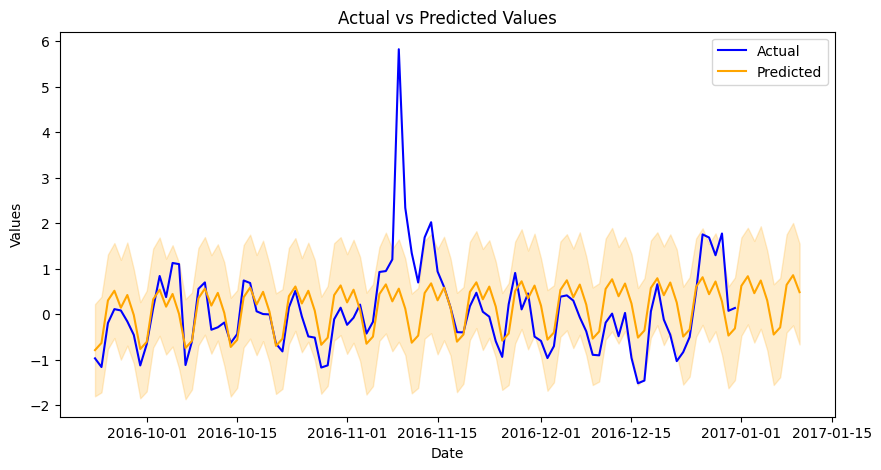

In [53]:
prophet_data = data_aggregated[['date', 'scaled_visits']].rename(columns={'date': 'ds', 'scaled_visits': 'y'})

train_size = int(0.8 * len(prophet_data))
prophet_train_data = prophet_data.iloc[:train_size]
prophet_test_data = prophet_data.iloc[train_size:]

model = Prophet()
model.fit(prophet_train_data)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

predicted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
predicted_values.rename(columns={'yhat': 'Predicted', 'ds': 'Date'}, inplace=True)

actual_values = prophet_data.rename(columns={'y': 'Actual', 'ds': 'Date'})
combined = pd.merge(actual_values, predicted_values, on='Date', how='outer')

plt.figure(figsize=(10, 5))
plt.plot(combined['Date'], combined['Actual'], label='Actual', color='blue')
plt.plot(combined['Date'], combined['Predicted'], label='Predicted', color='orange')
plt.fill_between(combined['Date'], combined['yhat_lower'], combined['yhat_upper'], color='orange', alpha=0.2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [55]:
actual_values = combined['Actual']
predicted_values = combined['Predicted']

prophet_rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))

print(f'RMSE: {prophet_rmse}')

RMSE: 0.848246884493887


4. XGBoost

In [59]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [83]:
y_pred_log = model.predict(X_test)

# Reversing log transformation
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

rmse = root_mean_squared_error(y_test_original, y_pred)
print(f'XGBoost Root Mean Squared Error: {rmse}')

XGBoost Root Mean Squared Error: 0.07554361548813049


In [65]:
# Hyperparameter tuning: n_estimators
n_estimators_values = [200, 100, 250]

for n in n_estimators_values:
    model = xgb.XGBRegressor(n_estimators=n, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_actual = np.exp(y_test)
    
    rmse = root_mean_squared_error(y_test_actual, y_pred)
    print(f'n_estimators={n} -> RMSE: {rmse}')

n_estimators=200 -> RMSE: 0.06655592977424174
n_estimators=100 -> RMSE: 0.06660189725834872
n_estimators=250 -> RMSE: 0.06655570858770021


In [67]:
# Hyperparameter tuning: learning_rate
learning_rate_values = [0.01, 0.05, 0.1, 0.2]

for lr in learning_rate_values:
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_actual = np.exp(y_test)
    
    rmse = root_mean_squared_error(y_test_actual, y_pred)
    print(f'learning_rate={lr} -> RMSE: {rmse}')

learning_rate=0.01 -> RMSE: 0.2042467754909097
learning_rate=0.05 -> RMSE: 0.06651726398223602
learning_rate=0.1 -> RMSE: 0.06655592977424174
learning_rate=0.2 -> RMSE: 0.06515610506074938


In [69]:
learning_rate_values = [.5, .55, .52, .58]

for lr in learning_rate_values:
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_actual = np.exp(y_test)
    
    rmse = root_mean_squared_error(y_test_actual, y_pred)
    print(f'learning_rate={lr} -> RMSE: {rmse}')

learning_rate=0.5 -> RMSE: 0.07327339599888032
learning_rate=0.55 -> RMSE: 0.07571169412312594
learning_rate=0.52 -> RMSE: 0.06974821199864793
learning_rate=0.58 -> RMSE: 0.1495854205741619


In [72]:
# Max_depth, subsample, grid_search...
max_depth_values = [3, 5, 7, 10]

for md in max_depth_values:
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.5, max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_actual = np.exp(y_test)
    
    rmse = root_mean_squared_error(y_test_actual, y_pred)
    print(f'max depth={md} -> RMSE: {rmse}')

max depth=3 -> RMSE: 0.08156252648111625
max depth=5 -> RMSE: 0.06326830820704038
max depth=7 -> RMSE: 0.07260631576332569
max depth=10 -> RMSE: 0.07554365384790884


In [74]:
max_depth_values = [10, 12, 14, 16]

for md in max_depth_values:
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.5, max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_actual = np.exp(y_test)
    
    rmse = root_mean_squared_error(y_test_actual, y_pred)
    print(f'max depth={md} -> RMSE: {rmse}')

max depth=10 -> RMSE: 0.07554365384790884
max depth=12 -> RMSE: 0.07570095059532118
max depth=14 -> RMSE: 0.0758821971061488
max depth=16 -> RMSE: 0.0758821971061488


In [76]:
max_depth_values = [10, 11]

for md in max_depth_values:
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.5, max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_actual = np.exp(y_test)
    
    rmse = root_mean_squared_error(y_test_actual, y_pred)
    print(f'max depth={md} -> RMSE: {rmse}')

max depth=10 -> RMSE: 0.07554365384790884
max depth=11 -> RMSE: 0.07610531070863588


In [79]:
subsample_values = [0.1, 0.2, 0.3, 0.4, 1]

for ss in subsample_values:
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.5, max_depth=10, subsample=ss, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_actual = np.exp(y_test)
    
    rmse = root_mean_squared_error(y_test_actual, y_pred)
    print(f'subsample={ss} -> RMSE: {rmse}')

subsample=0.1 -> RMSE: 1.0035241923592362
subsample=0.2 -> RMSE: 0.5088323802178991
subsample=0.3 -> RMSE: 0.21857568895947016
subsample=0.4 -> RMSE: 0.14213472291002133
subsample=1 -> RMSE: 0.07554365384790884


In [96]:
param_grid = {
    'learning_rate': [0.4, 0.5, 0.6], 
    'n_estimators': [180, 200, 220], 
    'max_depth': [5, 10, 12], 
    'subsample': [0.25, 0.5, 1]}

xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

y_pred_log = grid_search.best_estimator_.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_actual = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

Best Parameters: {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 180, 'subsample': 1}
Best RMSE: 0.4019872482151507


5. KERAS

In [86]:
model = Sequential()

model.add(Input(shape=(X_train.shape[1],))) 
model.add(Dense(64, activation='relu')) 
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
print(f"Deep Learning Model RMSE: {rmse}")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 19163.9492 - val_loss: 1399.2089
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 885.3128 - val_loss: 2278.1516
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2822.5403 - val_loss: 3703.8601
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3175.5198 - val_loss: 765.3006
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 482.3825 - val_loss: 213.9624
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 444.1298 - val_loss: 1228.7954
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1223.3307 - val_loss: 632.5200
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 484.6774 - val_loss: 0.9811
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.8832 - val_loss: 373.2202
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 398.5174 - val_loss: 386.8599
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 304.6310 - val_loss: 29.5722
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━